In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [5]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [6]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [7]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [23]:
ml_list={
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=7,max_features=8,min_samples_split=2,n_estimators=98)},
# "SVM":{"SYN":SVC(gamma=1,C=10)},
"NB":{"SYN":GaussianNB(var_smoothing=1.23285e-09)}
}


In [9]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [10]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [11]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [12]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  
                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [13]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  

            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [14]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [26]:
file_list={
'./INPUT/SW/DoS-SYN-1.csv':"SYN",
}

./INPUT/SW/DoS-SYN-1.csv
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    1        1       1      1      1      0.999  1        1.222     0.019
 1  SYN           0    2     0  RF    1        1       1      1      1      1      1        1.178     0.018
 2  SYN           0    3     0  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.111   

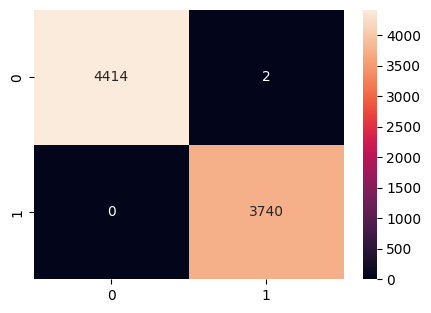





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.993    0.993   0.993  0.993  0.993  0.986  0.993    0.012     0.003
 1  SYN           0    2     0  NB    0.993    0.994   0.993  0.994  0.993  0.987  0.994    0.013     0.004
 2  SYN           0    3     0  NB    0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.012     0.004
 3  SYN           0    4     0  NB    0.994    0.994   0.994  0.994  0.994  0.988  0.994    0.013     0.003
 4  SYN           0    5     0  NB    0.993    0.993   0.993  0.993  0.993  0.986  0.993    0.013     0.003
 5  SYN           0    1     1  NB    0.993    0.993   0.993  0.993  0.993  0.986  0.993    0.013     0.004
 6  SYN           0    2     1  NB    0.994    0.994   0.994  0.994  0.994  0.988  0.994    0.015     0.004
 7  SYN           0    3

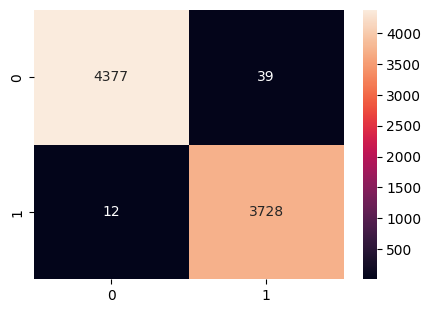

In [27]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    # target_names=["0",file_list[file]]
    target_names=[0,1]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [21]:
file_list={
    "SYN":['./INPUT/SM/DoS-SYN-1.csv','./INPUT/SW/DoS-SYN-2.csv'],
# "SYN_ARP":['./train-data/train_syn_arp_data.csv','./test/syn-arp-attack-train.csv'],
# "HTTP":['./INPUT/SM/MB-HTTP-4.csv','./INPUT/SW/MB-HTTP-1.csv'],
# "ACK":['./INPUT/SM/MB-ACK-4.csv','./INPUT/SW/MB-ACK-1.csv'],
# "UDP":['./INPUT/SM/MB-UDP-4.csv','./INPUT/SW/MB-UDP-1.csv'],
# "ARP":['./INPUT/SM/MitM-ARP-6.csv','./INPUT/SW/MitM-ARP-4.csv'],  
# "SP":['./INPUT/SM/Scan-Port-3.csv','./INPUT/SW/Scan-Port-4.csv'],
# "BF":['./INPUT/SM/MB-BF-5.csv','./INPUT/SW/MB-BF-3.csv'],
# "OS":['./INPUT/SM/Scan-OS-3.csv','./INPUT/SW/Scan-OS-6.csv'],
# "SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SW/MB-HDis-2.csv'],
# "MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SW/Scan-HDis-4.csv' ]
}
 

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    0.976    0.972   0.98   0.972  0.975  0.95   0.972    1.165     0.063
 1  SYN           0    1     1  RF    0.95     0.942   0.96   0.942  0.948  0.897  0.942    1.169     0.061
 2  SYN           0    1     2  RF    0.997    0.997   0.997  0.997  0.997  0.994  0.997    1.232     0.059
 3  SYN      

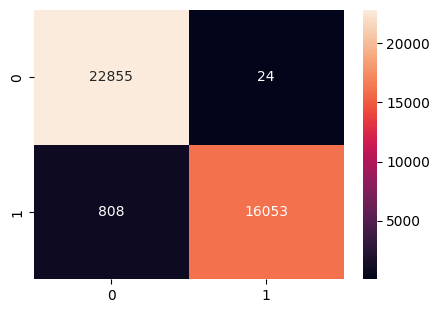





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.016     0.019
 1  SYN           0    1     1  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.019     0.018
 2  SYN           0    1     2  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.016     0.016
 3  SYN           0    1     3  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.017     0.019
 4  SYN           0    1     4  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.016     0.017
 5  SYN           0    1     5  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.014     0.018
 6  SYN           0    1     6  NB    0.945    0.937   0.953  0.937  0.943  0.886  0.937    0.017     0.019
 7  SYN           0    1

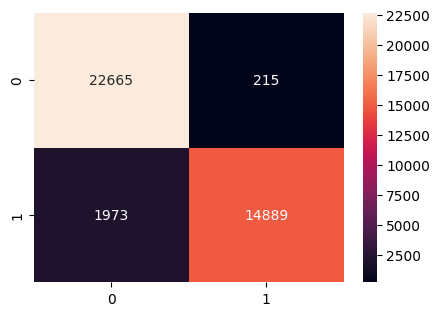

In [24]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    # target_names=["Benign",file]
    target_names=[0,1]
    ML(train,test,output_csv,feature,file,0)   


In [18]:
import time

# sleep for 3 seconds
print('Sleep time: ', str(3600), 'seconds')
time.sleep(3600)
print('Woke up after: ', str(3), 'seconds')


Sleep time:  3600 seconds
Woke up after:  3 seconds


# TEST

In [40]:
file_list={
'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
#  'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
# 'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
#  'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
#  'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
#  'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
#  'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
#  'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
# "SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SW/MB-HDis-3.csv'],
# "MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SW/Scan-HDis-3.csv' ]
}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  RF    0.917    0.929   0.917  0.929  0.916  0.834  0.929    1.337     0.222
 1  SYN           1    1     1  RF    0.917    0.929   0.917  0.929  0.916  0.834  0.929    1.259     0.205
 2  SYN           1    1     2  RF    0.917    0.929   0.917  0.929  0.916  0.834  0.929    1.915     0.521
 3  SYN      

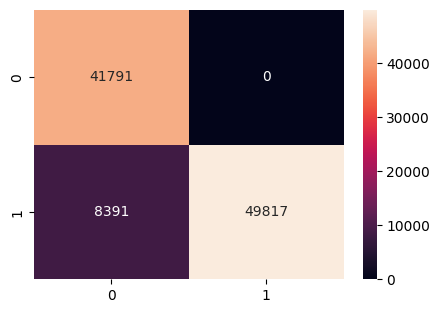

KeyboardInterrupt: 

In [42]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    # target_names=[0,1]
    target_names=[0,1]
    ML(train,test,output_csv,feature,file,1)  


In [22]:
print(2)

2


In [ ]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

In [ ]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)